# Support Vector Machines

This week we'll look at building support vector machine classifiers in scikit-learn.

There are several approaches.
* `SVC` - support vector classifier. Can be used on binary and multi-class problems. Uses the `C` parameter to control the regularisation. C defaults to 1, use lower values (down to minumum of 0) if you have noisy data. This causes more regularisation.
* `NuSVC` - similar to above except it uses a parameter nu to control the number of support vectors. nu is between 0 and 1. It is the maximum proportion of margin bound errors. In other words, it controls the softness of the SVM.
* `LinearSVC` - Unlike SVC and NuSVC this only allows a linear kernel but is optimised to be faster.

You can read more about using SVMs here: https://scikit-learn.org/stable/modules/svm.html#svm-classification

In particular they can be a bit sensitive. Data should be normalised, you may need to increase the size of the memory cache and they can be slow to train. The user guide gives tips for getting them to work more effectively.

First off, let's import the packages we want and load the data file as we have done previously. Then we'll take a look with `head()` to see if it looks ok.

**Remember to change `DATAFILE` below**

In [1]:
import sklearn as sk
import pandas as pd

DATAFILE = '/Users/990679/OneDrive - UTS/uni/teaching/IDA20S/lectures/week7/iris.csv'
iris = pd.read_csv(DATAFILE)

In [2]:
iris.head()

,Row,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


Let's now split the data into an `X` and `y` and then create a training and test split.

In [3]:
# Make the target numeric, and create training and test sets.
targets = iris['Species'].unique()
target2code = dict(zip(targets, range(len(targets))))

X = iris.iloc[:,1:-1] # strip off the row number and target.
y = iris.iloc[:,-1].copy() # don't want to overwrite the original 
y = y.apply(lambda x: target2code[x]) # convert each 

# Now split these into a training / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (105, 4)
y_train: (105,)
X_test: (45, 4)
y_test: (45,)


# NuSVC

Personally I prefer NuSVC because it allows you to limit the proportion of misclassifications, but the other versions are fine as well. So we'll use `sklearn.svm.NuSVC`. As usual, to get started we'll just use the default parameters and then `fit` the data to the classifier. However, do look at the web page and have a play around.

Some attributes of interest to pass to the classifier are:
* `nu` is the upper bound on the proportion of margin errors you're happy to accept
* `kernel` is the type of kernel to use. You can select 'linear', 'poly', 'rbf',  'sigmoid' or 'precomputed' (if you want to use your own kernel). Defaults to 'rbf'
* `poly`, `gamma`, `coef0` are parameters for the various kernels
* `probability` is whether to calculte the class probabilities. Defaults to False. For SVM this will cause the training to be much slower.
* `cache_size` allows you to give more memory to the kernel cache (will be faster if yu have the memory available).
* `class_weight` controls how to deal with unbalanced datasets


In [11]:
from sklearn.svm import NuSVC

clf = NuSVC(probability=True)
clf.fit(X_train, y_train)

NuSVC(probability=True)

Let's look at the classifier, then look at the prediction for a particular point in the test set.

In [13]:
# We can print the classifier like this.
print(clf)

# The number of support vectors in each class
print("Numbers of support vectors for each class:", clf.n_support_)

# The indices of the support vectors
print("Support vector indexes in the training set:", clf.support_)

# The support vectors
print("Support vectors in the training set:", clf.support_vectors_.shape)

# Let's look at one specific prediction.
test_idx = 21
test_point = X_test.iloc[test_idx]

pred_test = clf.predict([test_point])
pred_test_probs = clf.predict_proba([test_point]) # only works if probability=True in constructor

#print("Testing point", test_idx, "; predicted as", pred_test[0],
#      "; actually", y_test.iloc[test_idx])

print("Testing point", test_idx, "; predicted as", pred_test[0],
      "; actually", y_test.iloc[test_idx], "; probabilities", pred_test_probs[0])

NuSVC(probability=True)
Numbers of support vectors for each class: [22 34 22]
Support vector indexes in the training set: [  1   8  16  20  21  25  26  31  32  41  44  45  60  62  63  67  79  83
  93  95  96  98   0   3   5  10  13  17  28  30  34  35  37  42  51  52
  53  54  58  59  68  71  72  74  81  84  85  86  87  88  89  90  94  97
 100 104   2   6  12  15  18  23  27  33  38  39  40  48  55  57  64  69
  73  75  77  91  92 101]
Support vectors in the training set: (78, 4)
Testing point 21 ; predicted as 2 ; actually 2 ; probabilities [0.01006583 0.00541275 0.98452143]


Like we did last week, let's make predictions for the test partition, print the classification report and the confusion matrix.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.81      0.90        16
           2       0.83      1.00      0.91        15

    accuracy                           0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.94      0.93      0.93        45



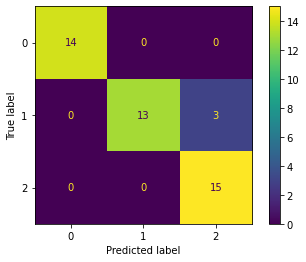

In [14]:
y_pred = clf.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test);

Finally, let's plot the ROC curve and work out the AUC value.

Because `iris` is a multi-class problem it's a bit trickier. We're goint to try to plot an ROC curve for each class (one vs the rest). First we need to work out the probabilities for the classes for each test point.

Then we use the `roc_auc_score` function to work out the AUC value.

Plotting the ROC curve is a bit more cumbersome. We need to loop over each class and then use the `roc_curve` function to return the TPRs and FPRs corresponding to a set of decision thresholds for that class vs the rest.

The AUC is 0.995


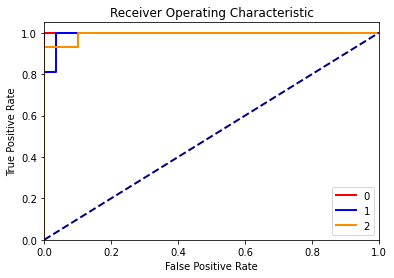

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the probabilities of each class.
y_probs = clf.predict_proba(X_test)

# The AUC score needs to be handled differently to get one number out of the three classes.
# We're going to average it over the three classes (one vs rest) weighted by the size of each
# class. The help gives the other option: ovo.
# auc = roc_auc_score(y_test, y_probs, multi_class="ovo", average="weighted")
auc = roc_auc_score(y_test, y_probs, multi_class="ovr", average="weighted")
print('The AUC is %.3f' % auc)

# Now let's plot the ROC curve.
import matplotlib.pyplot as plt
plt.figure()
col = { 0: "red", 1: "blue", 2:"darkorange"} # colour for each class
lw = 2 # the line width
# draw a line for each class (as the positive class)
for pos in range(3):
     fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,pos], pos_label=pos)
     plt.plot(fpr, tpr, color=col[pos], lw=lw, label='%d' % pos)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed line for random choice
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()